In [15]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

## **a) Implement the CartPole environment for a certain number of steps**

In [25]:
# Initialize the environment
env = gym.make('CartPole-v0')

# Set the number of steps
steps = 100

# Reset the environment and get the initial state
state = env.reset()

# Initialize the score
score = 0

# Loop for the specified number of steps
for step in range(steps):
    # Select a random action
    action = env.action_space.sample()
    
    # Take the action and get the new state, reward, and whether the episode is done
    new_state, reward, done, _ = env.step(action)
    
    # Update the state and the score
    state = new_state
    score += reward
    
    # Print information about the state
    print("Step:", step,"Reward:", reward, "Score:", score)
    # print("State:", state)
    # print("Action:", action)
    # print("Reward:", reward)
    # print("Done:", done)
    
    
    # Check if the episode is done
    if done:
        break

# Close the environment
env.close()


Step: 0 Reward: 1.0 Score: 1.0
Step: 1 Reward: 1.0 Score: 2.0
Step: 2 Reward: 1.0 Score: 3.0
Step: 3 Reward: 1.0 Score: 4.0
Step: 4 Reward: 1.0 Score: 5.0
Step: 5 Reward: 1.0 Score: 6.0
Step: 6 Reward: 1.0 Score: 7.0
Step: 7 Reward: 1.0 Score: 8.0
Step: 8 Reward: 1.0 Score: 9.0
Step: 9 Reward: 1.0 Score: 10.0
Step: 10 Reward: 1.0 Score: 11.0
Step: 11 Reward: 1.0 Score: 12.0
Step: 12 Reward: 1.0 Score: 13.0
Step: 13 Reward: 1.0 Score: 14.0
Step: 14 Reward: 1.0 Score: 15.0
Step: 15 Reward: 1.0 Score: 16.0
Step: 16 Reward: 1.0 Score: 17.0
Step: 17 Reward: 1.0 Score: 18.0
Step: 18 Reward: 1.0 Score: 19.0


## **b) Implement the CartPole environment for a certain number of episodes**

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [17]:
env = gym.make('CartPole-v0')
env.seed(0)

print('observation space:', env.observation_space)
print('action space:', env.action_space)

observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
action space: Discrete(2)


/usr/local/lib/python3.8/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` inste

In [18]:
class Policy(nn.Module):
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        # we just consider 1 dimensional probability of action
        return F.softmax(x, dim=1)
    
    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)

In [19]:
def reinforce(policy, optimizer, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))
        
        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        R = sum([a * b for a,b in zip(discounts, rewards)])
        
        # Calculate the loss 
        policy_loss = []
        for log_prob in saved_log_probs:
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * R)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()
        
        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()
        
        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [20]:
policy = Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
scores = reinforce(policy, optimizer, n_episodes=2000)

Episode 100	Average Score: 18.38
Episode 200	Average Score: 32.82
Episode 300	Average Score: 45.29
Episode 400	Average Score: 61.26
Episode 500	Average Score: 67.80
Episode 600	Average Score: 54.74
Episode 700	Average Score: 84.57
Episode 800	Average Score: 106.12
Episode 900	Average Score: 117.23
Episode 1000	Average Score: 166.28
Episode 1100	Average Score: 162.56
Episode 1200	Average Score: 148.20
Episode 1300	Average Score: 148.28
Episode 1400	Average Score: 176.78
Episode 1500	Average Score: 176.77
Environment solved in 1437 episodes!	Average Score: 195.46


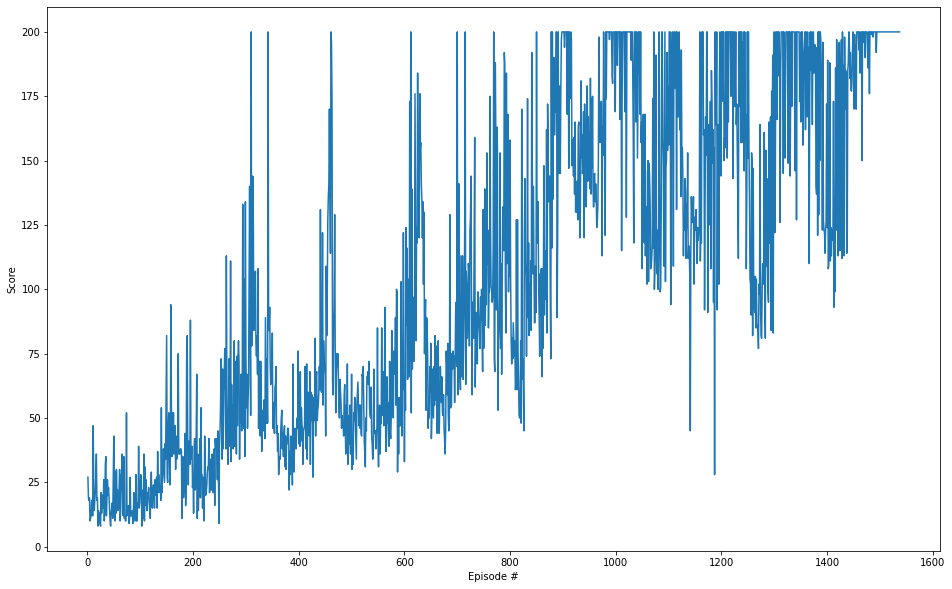

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

C)

When implementing the CartPole environment for a certain number of steps, the agent will receive a reward for each step that it keeps the pole balanced. However, this approach may lead to the agent getting stuck in a sub-optimal solution where it only receives a low reward, even though it could have received a higher reward if it continued to take actions.

On the other hand, when implementing the CartPole environment for a certain number of episodes, the agent will receive a reward at the end of each episode. This reward will be the sum of all the rewards earned during the episode. This approach may lead to a better representation of the agent's overall performance, as it takes into account the entire episode, rather than just a limited number of steps.

In conclusion, both approaches have their own advantages and disadvantages. The choice between the two will depend on the specific problem and the desired evaluation metric.